# Utilities in PECOS

PECOS provides various useful interfaces and utility functions for XMR problems and related tasks. In this session, we will introduce how to tackle arbitrary data formats for XMR, and then present some utilities in PECOS for efficient matrix operations and hierarchical clustering.

## Working with Arbitrary Data Formats

PECOS is a general machine learning framework and able to fit arbitary data format and interact with different data manipulation and analysis libraries like [Pandas](https://pandas.pydata.org/). In the following example, we will show how to learn a PECOS model with Pandas-loaded data of text, categorical, and numerical features.

In [1]:
import pecos
import pandas as pd
import numpy as np

In [2]:
! wget -nv -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00461/drugLib_raw.zip
! unzip -o drugLib_raw.zip

Archive:  drugLib_raw.zip
  inflating: drugLibTest_raw.tsv     
  inflating: drugLibTrain_raw.tsv    


In [3]:
train_df = pd.read_csv("drugLibTrain_raw.tsv", sep="\t")
test_df =  pd.read_csv("drugLibTest_raw.tsv", sep="\t")
print(f"Training DataFrame consists of {len(train_df)} instances.")
print(f"Testing DataFrame consists of {len(test_df)} instances.")
print(train_df.columns)

Training DataFrame consists of 3107 instances.
Testing DataFrame consists of 1036 instances.
Index(['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')


In [4]:
label_name = "effectiveness"
text_features = ["condition", "benefitsReview", "sideEffectsReview", "commentsReview"]
categorical_features = ["sideEffects"]
numerical_features = ["rating"]

In [5]:
X_trn_list = []
X_tst_list = []

### Label Encoding

To encode labels into the sparse matrix format compatible to PECOS, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn.preprocessing.MultiLabelBinarizer) and [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn.preprocessing.MultiLabelBinarizer) are helpful for the scenarios of multi-class and multi-label classification.

In [6]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder(dtype=np.float32)
Y_trn = label_encoder.fit_transform(train_df[[label_name]])
Y_tst = label_encoder.transform(test_df[[label_name]])

print(f"Y_trn is a {Y_trn.getformat()} matrix with a shape {Y_trn.shape} and {Y_trn.nnz} non-zero values.")
print(f"Y_tst is a {Y_tst.getformat()} matrix with a shape {Y_tst.shape} and {Y_tst.nnz} non-zero values.")

Y_trn is a csr matrix with a shape (3107, 5) and 3107 non-zero values.
Y_tst is a csr matrix with a shape (1036, 5) and 1036 non-zero values.


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

label_encoder_multilabel = MultiLabelBinarizer(sparse_output=True)
Y_trn_mlb = label_encoder.fit_transform([[lbl] for lbl in train_df[label_name].tolist()])
Y_tst_mlb = label_encoder.fit_transform([[lbl] for lbl in test_df[label_name].tolist()])
print(f"Y_trn_mlb is a {Y_trn_mlb.getformat()} matrix with a shape {Y_trn_mlb.shape} and {Y_trn_mlb.nnz} non-zero values.")
print(f"Y_tst_mlb is a {Y_tst_mlb.getformat()} matrix with a shape {Y_tst_mlb.shape} and {Y_tst_mlb.nnz} non-zero values.")

Y_trn_mlb is a csr matrix with a shape (3107, 5) and 3107 non-zero values.
Y_tst_mlb is a csr matrix with a shape (1036, 5) and 1036 non-zero values.


### Text Feature Encoding

As introduced in Session 1, we can use PECOS vectorizer for featurize text data. In addition, the encoder of [XR-Transformer](https://github.com/amzn/pecos/tree/mainline/pecos/xmc/xtransformer) can be also utilized for deriving text features with proper fine-tuning.

In [8]:
from pecos.utils.featurization.text.vectorizers import Vectorizer

for feature_name in text_features:
    vectorizer_config = {
        "type": "tfidf",
        "kwargs": {
          "base_vect_configs": [

            {
              "ngram_range": [1, 2],
              "max_df_ratio": 0.98,
              "analyzer": "word",
            },
          ],
        },
      }   
    train_texts = [str(x) for x in train_df[feature_name].tolist()]
    test_texts = test_df[feature_name].tolist()
    vectorizer = Vectorizer.train(train_texts, config=vectorizer_config)
    X_trn_local = vectorizer.predict(train_texts)
    X_tst_local = vectorizer.predict(test_texts)
    print(f"{feature_name}: {X_trn_local.shape} and {X_tst_local.shape} in training and testing.")
    
    X_trn_list.append(X_trn_local)
    X_tst_list.append(X_tst_local)

condition: (3107, 3759) and (1036, 3759) in training and testing.
benefitsReview: (3107, 72861) and (1036, 72861) in training and testing.
sideEffectsReview: (3107, 64321) and (1036, 64321) in training and testing.
commentsReview: (3107, 91731) and (1036, 91731) in training and testing.


### Categorical Feature Encoding

Similar to labels, categorical features can also be considered as one-hot or multi-hot embeddings.

In [9]:
from sklearn.preprocessing import OneHotEncoder

for feature_name in categorical_features:
    local_encoder = OneHotEncoder(dtype=np.float32)
    X_trn_local = local_encoder.fit_transform(train_df[[feature_name]])
    X_tst_local = local_encoder.transform(test_df[[feature_name]])
    print(f"{feature_name}: {X_trn_local.shape} and {X_tst_local.shape} in training and testing.")
    
    X_trn_list.append(X_trn_local)
    X_tst_list.append(X_tst_local)

sideEffects: (3107, 5) and (1036, 5) in training and testing.


### Numerical Features Encoding

Numberical features can be directly incorporated as model inputs after some simple normalization.

In [10]:
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

for feature_name in numerical_features:
    X_trn_values = train_df[["rating"]].values
    X_tst_values = test_df[["rating"]].values
    scaler = StandardScaler()
    X_trn_local = csr_matrix(scaler.fit_transform(X_trn_values), dtype=np.float32)
    X_tst_local = csr_matrix(scaler.transform(X_tst_values), dtype=np.float32)
    print(f"{feature_name}: {X_trn_local.shape} and {X_tst_local.shape} in training and testing.")
    
    X_trn_list.append(X_trn_local)
    X_tst_list.append(X_tst_local)

rating: (3107, 1) and (1036, 1) in training and testing.


### Feature Concatenation

PECOS provides easy-going utility functions for efficient matrix operations. The `hstack_csr` function can concatenate different features for each individual instance.  More detils about other utilities will be introduced later in this session.

In [11]:
from pecos.utils import smat_util

X_trn = smat_util.hstack_csr(X_trn_list)
X_tst = smat_util.hstack_csr(X_tst_list)

print(f"X_trn is a {X_trn.getformat()} matrix with a shape {X_trn.shape} and {X_trn.nnz} non-zero values.")
print(f"X_tst is a {X_tst.getformat()} matrix with a shape {X_tst.shape} and {X_tst.nnz} non-zero values.")

X_trn is a csr matrix with a shape (3107, 232678) and 653987 non-zero values.
X_tst is a csr matrix with a shape (1036, 232678) and 164272 non-zero values.


### Model Training and Testing

In [12]:
from pecos.xmc.xlinear.model import XLinearModel
xlm = XLinearModel.train(X_trn, Y_trn)

Y_pred = xlm.predict(X_tst, beam_size=10, only_topk=5)
metrics = smat_util.Metrics.generate(Y_tst, Y_pred, topk=5)
print(metrics)

prec   = 52.80 40.69 30.92 24.52 20.00
recall = 52.80 81.37 92.76 98.07 100.00


## Sparse Matrix Operations

Most of the computations in PECOS are based on sparse matrices, so PECOS also provides various useful and efficient operation utilities for sparse matrices.

### Genric Matriox IO and Conversion

`smat_util.load_matrix` and `smat_util.save_matrix` provide generic interfaces for loading and storing matrices in arbitrary common formats, including [dense matrix](https://numpy.org/doc/stable/reference/generated/numpy.array.html) in NumPy or different sparse matrix formats (i.e., [sparse Compressed Sparse Row (CSR) matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html),  [sparse Compressed Sparse Column (CSC) matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html), and  [sparse COOrdinate (COO) matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)).

In [13]:
from pecos.utils import smat_util
import numpy as np
import scipy.sparse as smat

print("Dense Matrtix IO")
mat = np.random.rand(2, 3)
print(f"mat is a {type(mat)} matrix with a shape {mat.shape}.")
print(mat)
smat_util.save_matrix("mat.npz", mat)
mat_loaded = smat_util.load_matrix("mat.npz")
print(f"mat_loaded is a {type(mat_loaded)} matrix with a shape {mat_loaded.shape}.")
print(mat)
print("")    

for matrix_format in ["csr", "csc", "coo"]:
    print(f"{matrix_format} Sparse Matrix IO")
    mat = smat.random(5, 4, density=0.2, format=matrix_format)
    print(f"mat is a {type(mat)} matrix"
          f" with a shape {mat.shape} and {mat.nnz} non-zero values.")
    print(mat)
    
    smat_util.save_matrix("mat.npz", mat)
    mat_loaded = smat_util.load_matrix("mat.npz")
    print(f"mat_loaded is a {type(mat_loaded)} matrix"
          f" with a shape {mat_loaded.shape} and {mat_loaded.nnz} non-zero values.")
    print(mat_loaded)
    print("")    

Dense Matrtix IO
mat is a <class 'numpy.ndarray'> matrix with a shape (2, 3).
[[0.6757516  0.42168422 0.40557039]
 [0.86806547 0.9198075  0.7494449 ]]
mat_loaded is a <class 'numpy.ndarray'> matrix with a shape (2, 3).
[[0.6757516  0.42168422 0.40557039]
 [0.86806547 0.9198075  0.7494449 ]]

csr Sparse Matrix IO
mat is a <class 'scipy.sparse.csr.csr_matrix'> matrix with a shape (5, 4) and 4 non-zero values.
  (1, 2)	0.17821196669035588
  (2, 1)	0.8259001065480657
  (4, 2)	0.5111159408743305
  (4, 3)	0.6337428297507509
mat_loaded is a <class 'scipy.sparse.csr.csr_matrix'> matrix with a shape (5, 4) and 4 non-zero values.
  (1, 2)	0.17821196669035588
  (2, 1)	0.8259001065480657
  (4, 2)	0.5111159408743305
  (4, 3)	0.6337428297507509

csc Sparse Matrix IO
mat is a <class 'scipy.sparse.csc.csc_matrix'> matrix with a shape (5, 4) and 4 non-zero values.
  (0, 1)	0.868116915403953
  (1, 2)	0.7454473997071077
  (0, 3)	0.21167432752493887
  (1, 3)	0.4685535255015949
mat_loaded is a <class 'scip

In [14]:
mat = np.random.rand(4, 6)

print(f"Original Matrix mat\n", mat, "\n")

print("csr_mat = dense_to_csr(mat)")
csr_mat = smat_util.dense_to_csr(mat)
print(f"csr_mat is a {type(csr_mat)} matrix"
      f" with a shape {csr_mat.shape} and {csr_mat.nnz} non-zero values.")
print(csr_mat.toarray(), "\n")

print("csr_mat_topk = dense_to_csr(mat, topk=2)")
csr_mat_topk = smat_util.dense_to_csr(mat, topk=2)
print(f"csr_mat is a {type(csr_mat_topk)} matrix"
      f" with a shape {csr_mat_topk.shape} and {csr_mat_topk.nnz} non-zero values.")
print(csr_mat_topk.toarray(), "\n")

Original Matrix mat
 [[7.75480297e-01 3.06141999e-01 1.48439313e-01 4.82371302e-01
  7.94080899e-01 4.22684703e-04]
 [1.22368102e-01 9.06639305e-02 5.88889479e-01 3.37880581e-01
  7.45595442e-01 9.58851999e-01]
 [5.65962202e-01 7.18344997e-01 1.99721347e-01 2.02474399e-01
  5.86650110e-01 1.93471414e-01]
 [5.72012816e-02 1.20470044e-01 1.27986695e-01 6.43206432e-01
  5.42874998e-01 7.05113274e-01]] 

csr_mat = dense_to_csr(mat)
csr_mat is a <class 'scipy.sparse.csr.csr_matrix'> matrix with a shape (4, 6) and 24 non-zero values.
[[7.75480297e-01 3.06141999e-01 1.48439313e-01 4.82371302e-01
  7.94080899e-01 4.22684703e-04]
 [1.22368102e-01 9.06639305e-02 5.88889479e-01 3.37880581e-01
  7.45595442e-01 9.58851999e-01]
 [5.65962202e-01 7.18344997e-01 1.99721347e-01 2.02474399e-01
  5.86650110e-01 1.93471414e-01]
 [5.72012816e-02 1.20470044e-01 1.27986695e-01 6.43206432e-01
  5.42874998e-01 7.05113274e-01]] 

csr_mat_topk = dense_to_csr(mat, topk=2)
csr_mat is a <class 'scipy.sparse.csr.csr_

### Memory-efficient Sparse Matrix Operations

To manipulate with sparse matrix, PECOS provides many useful memory-efficient functions. For example, for CSR matrices, we have following functions to combine multiple matrices.

* `hstack_csr([mat, mat, mat]`
* `vstack_csr([mat, mat, mat]`
* `block_diag_csr([mat, mat, mat]`

These funcations are also available for CSC matrices as `hstack_csc`, `vstack_csr`, and `block_diag_csr`.


In [15]:
from pecos.utils import smat_util
import scipy.sparse as smat

mat = smat.random(3, 2, density=0.5, format="csr")
print(f"Original Matrix {type(mat)} mat\n", mat.toarray(), "\n")

print(f"hstack_csr([mat, mat, mat])")
print(smat_util.hstack_csr([mat, mat, mat]).toarray(), "\n")

print(f"vstack_csr([mat, mat, mat])")
print(smat_util.vstack_csr([mat, mat, mat]).toarray(), "\n")

print(f"block_diag_csr([mat, mat, mat])")
print(smat_util.block_diag_csr([mat, mat, mat]).toarray(), "\n")

Original Matrix <class 'scipy.sparse.csr.csr_matrix'> mat
 [[0.45989041 0.        ]
 [0.77400378 0.        ]
 [0.         0.44557291]] 

hstack_csr([mat, mat, mat])
[[0.45989041 0.         0.45989041 0.         0.45989041 0.        ]
 [0.77400378 0.         0.77400378 0.         0.77400378 0.        ]
 [0.         0.44557291 0.         0.44557291 0.         0.44557291]] 

vstack_csr([mat, mat, mat])
[[0.45989041 0.        ]
 [0.77400378 0.        ]
 [0.         0.44557291]
 [0.45989041 0.        ]
 [0.77400378 0.        ]
 [0.         0.44557291]
 [0.45989041 0.        ]
 [0.77400378 0.        ]
 [0.         0.44557291]] 

block_diag_csr([mat, mat, mat])
[[0.45989041 0.         0.         0.         0.         0.        ]
 [0.77400378 0.         0.         0.         0.         0.        ]
 [0.         0.44557291 0.         0.         0.         0.        ]
 [0.         0.         0.45989041 0.         0.         0.        ]
 [0.         0.         0.77400378 0.         0.         0.  

### Sparse-to-sparse Matrix Multiplication (SpMM)

Many operations in PECOS or XMR problems rely on Sparse-to-sparse Matrix Multiplication (SpMM), such as the computation of PIFA features. It is also one of the key primitives in large-scale linear algebra operations, with a broad range of applications in machine learning and natural language processing.

For SpMM, PECOS provides a highly optimized multi-core CPU implementation with state-of-the-art performance, where the underlying operations are implemented and optimized in C/C++.
Specifically, the Python interface and parameters are as follows:

```python
from pecos.core import clib as pecos_clib
Z = pecos_clib.sparse_matmul(X, Y, eliminate_zeros=False, sorted_indices=True, threads=-1)
```
* Parameters
    * `X` (scipy.sparse.csr_matrix or scipy.sparse.csc_matrix): the first sparse matrix to be multiplied.
    * `Y` (scipy.sparse.csr_matrix or scipy.sparse.csc_matrix): the second sparse matrix to be multiplied.
    * `eliminate_zeros` (bool, optional): if true, then eliminate (potential) zeros created by maxnnz in output matrix Z. Default is false.
    * `sorted_indices` (bool, optional): if true, then sort the Z.indices for the output matrix Z. Default is true.
    * `threads` (int, optional): The number of threads. Default -1 to use all CPU cores.

In [16]:
import numpy as np
import scipy.sparse as smat
from scipy.sparse import linalg
from pecos.core import clib as pecos_clib
X = smat.random(1000, 1000, density=0.01, format='csr', dtype=np.float32)
Y = smat.random(1000, 1000, density=0.01, format='csr', dtype=np.float32)
Z_true = X.dot(Y)
Z_pred = pecos_clib.sparse_matmul(X, Y)
print("||Z_true - Z_pred|| = ", linalg.norm(Z_true - Z_pred))

||Z_true - Z_pred|| =  0.0


In [17]:
import time
DATASET = "wiki10-31k"
X = smat_util.load_matrix(f"xmc-base/{DATASET}/tfidf-attnxml/X.trn.npz").astype(np.float32)
Y = smat_util.load_matrix(f"xmc-base/{DATASET}/Y.trn.npz").astype(np.float32)
YT_csr = Y.T.tocsr()
X_csr = X.tocsr()

#### Benchmarking Sparse Matrix Muplication

The SpMM utility has state-of-the-art performance in efficiency as shown in the following figure.

<div>
<br/><img src="imgs/pecos_spmm.png" width="60%"/>
</div>

In this part, we provide some hands-on instructions for benchmarking different methods for SpMM.

In [18]:
# Benchmarking SciPy

start = time.time()
Z = YT_csr.dot(X_csr)
Z.sort_indices()
run_time_scipy = time.time() - start

In [19]:
# Benchmarking PyTorch

import torch

def csr_to_coo(A):
    A_coo = smat.coo_matrix(A)
    indices = np.vstack([A_coo.row, A_coo.col]).T
    values = A_coo.data
    return indices, values

def get_pt_data(A_csr):
    A_indices, A_values = csr_to_coo(A_csr)
    A_pt = torch.sparse_coo_tensor(
        A_indices.T.astype(np.int64),
        A_values.astype(np.float32),
        A_csr.shape,
    )
    return A_pt
    
YT_pt = get_pt_data(YT_csr)
X_pt = get_pt_data(X_csr)
start = time.time()
Z_pt = torch.sparse.mm(YT_pt, X_pt)
run_time_pytorch = time.time() - start

In [20]:
# Benchmarking PECOS

start = time.time()
Z = pecos_clib.sparse_matmul(
    YT_csr, X_csr,
    eliminate_zeros=False,
    sorted_indices=True
)
run_time_pecos = time.time() - start

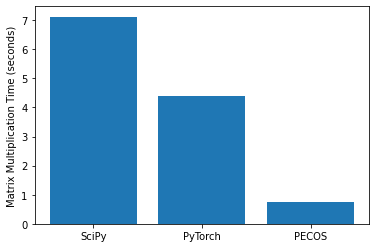

In [21]:
from matplotlib import pyplot as plt
plt.bar(
    [1,2,3],
    [run_time_scipy, run_time_pytorch, run_time_pecos],
    tick_label = ["SciPy", "PyTorch", "PECOS"])

plt.ylabel("Matrix Multiplication Time (seconds)");

## Hierarchical Clustering

Hierarchical clustering is an essential function for tree-based XMR models and plays a role of the indexer in PECOS. Accordingly, PECOS also implements hierarchical K-means algorithms in the manner of efficient C/C++, which can also be considered as useful functions for arbitrary tasks. The Python interface of PECOS hierarchical K-means algorithms is as follows:

```python
from pecos.xmc import HierarchicalKMeans
HierarchicalKMeans.gen(feature_matrix, ... [training parameters])
```
* Training Parameters
    * `nr_splits` (int, optional): The out-degree of each internal node of the tree. Ignored if `imbalanced_ratio != 0` because imbalanced clustering supports only 2-means. Default is `16`.
    * `min_codes` (int): The number of direct child nodes that the top level of the hierarchy should have.
    * `max_leaf_size` (int, optional): The maximum size of each leaf node of the tree. Default is `100`.
    * `spherical` (bool, optional): True will l2-normalize the centroids of k-means after each iteration. Default is `True`.
    * `seed` (int, optional): Random seed. Default is `0`.
    * `kmeans_max_iter` (int, optional): Maximum number of iterations for each k-means problem. Default is `20`.
    * `threads` (int, optional): Number of threads to use. `-1` denotes all CPUs. Default is `-1`.
    
#### Clustering Chains

Similar to the results of semantic label indexing in PECOS, the hierarchical clustering results will be returned as a list of `D` CSC matrices `C[d]` to denote hierarchical cluster assignments over layers, where `D` is the layers of resulting hierarchical clusters.

### Naive Clustering as Degenerated Hierarchical Clustering

When `min_codes` and `max_leaf_size` as the stopping criteria are large enough, the hierarchical clustering will be degenerated to conventional naive clustering.

In [22]:
from pecos.utils import smat_util
import time
DATASET = "wiki10-31k"
X = smat_util.load_matrix(f"xmc-base/{DATASET}/tfidf-attnxml/X.trn.npz").astype(np.float32)
Y = smat_util.load_matrix(f"xmc-base/{DATASET}/Y.trn.npz").astype(np.float32)
YT_csr = Y.T.tocsr()
X_csr = X.tocsr()

In [23]:
from pecos.xmc.base import HierarchicalKMeans
import scipy.sparse as smat
import numpy as np

num_splits = 4
cluster_chain = HierarchicalKMeans.gen(
    X_csr,
    min_codes=num_splits,
    nr_splits=num_splits,
    max_leaf_size=np.ceil(X_csr.shape[0]/num_splits))

print(f"{len(cluster_chain)} layers in the trained hierarchical clusters with C[d] as:")
for d, C in enumerate(cluster_chain):
    print(f"cluster_chain[{d}] is a {C.getformat()} matrix of shape {C.shape}.")

2 layers in the trained hierarchical clusters with C[d] as:
cluster_chain[0] is a csc matrix of shape (4, 1).
cluster_chain[1] is a csc matrix of shape (14146, 4).


(14146,) (14146,)


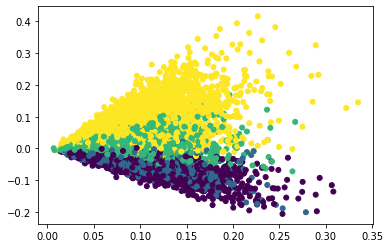

In [24]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_csr)

from matplotlib import pyplot as plt
cluster_x, cluster_y = X_svd[:, 0], X_svd[:, 1]
cluster_c = list(cluster_chain[-1].tocsr().indices)
print(cluster_x.shape, cluster_y.shape)
plt.scatter(cluster_x, cluster_y, c=cluster_c, s=25)

### Tracing Cluster in Hierarchical Clustering

In [25]:
from pecos.xmc.base import HierarchicalKMeans
import scipy.sparse as smat
import numpy as np

cluster_chain = HierarchicalKMeans.gen(X_csr, nr_splits=8)

print(f"{len(cluster_chain)} layers in the trained hierarchical clusters with C[d] as:")
for d, C in enumerate(cluster_chain):
    print(f"cluster_chain[{d}] is a {C.getformat()} matrix of shape {C.shape}.")

4 layers in the trained hierarchical clusters with C[d] as:
cluster_chain[0] is a csc matrix of shape (4, 1).
cluster_chain[1] is a csc matrix of shape (32, 4).
cluster_chain[2] is a csc matrix of shape (256, 32).
cluster_chain[3] is a csc matrix of shape (14146, 256).


In [26]:
from scipy.sparse import linalg
from pecos.core import clib as pecos_clib

current_cluster = cluster_chain[-1]
for i in range(len(cluster_chain) - 2, -1, -1):
    print(f"{current_cluster.getnnz(0)[0]} instances belong to the first cluster in the layer-{i + 1}.")
    current_cluster = pecos_clib.sparse_matmul(current_cluster, cluster_chain[i])

55 instances belong to the first cluster in the layer-3.
442 instances belong to the first cluster in the layer-2.
3536 instances belong to the first cluster in the layer-1.


In [27]:
inst_idx = 10

current_cluster = cluster_chain[-1]
for i in range(len(cluster_chain) - 2, -1, -1):
    print(f"The {inst_idx}-th instance belongs to the cluster-{current_cluster.tocsr().indices[inst_idx]} in the layer-{i + 1}.")
    current_cluster = pecos_clib.sparse_matmul(current_cluster, cluster_chain[i])

The 10-th instance belongs to the cluster-228 in the layer-3.
The 10-th instance belongs to the cluster-28 in the layer-2.
The 10-th instance belongs to the cluster-3 in the layer-1.


### Performance Benchmarking

Here we benchmark the efficiency performance of PECOS hierarchicaly clustering and compare with a pure Python implementation based on [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [28]:
import time
from pecos.xmc.base import HierarchicalKMeans

nr_splits = 4

start_time = time.time()
cluster_chain = HierarchicalKMeans.gen(X_csr, nr_splits=nr_splits)
pred_time = time.time() - start_time

cluster_depth = len(cluster_chain)
print(f"PECOS takes {pred_time:.4f} seconds for hierarchical clustering with a depth {cluster_depth}.")

PECOS takes 1.0543 seconds for hierarchical clustering with a depth 5.


In [29]:
from sklearn.cluster import KMeans
import numpy as np

start_time = time.time()
current_clusters = [X_csr]
for d in range(cluster_depth):
    next_clusters = []
    for cur_X in current_clusters:
        if cur_X.shape[0] >= nr_splits:
            kmeans = KMeans(n_clusters=nr_splits).fit(cur_X)
            next_clusters.append(cur_X[kmeans.labels_ == 0])
            next_clusters.append(cur_X[kmeans.labels_ == 1])
        else:
            next_clusters.append(cur_X)
        
    current_clusters = next_clusters
pred_time = time.time() - start_time

print(f"scikit-learn takes {pred_time:.4f} seconds for hierarchical clustering with a depth {cluster_depth}.")

scikit-learn takes 49.1826 seconds for hierarchical clustering with a depth 5.
